In [6]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict
import numpy as np
import pymc3 as pm
import theano.tensor as tt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

groups = generate_groups_data(data, groups_input, seasonality=12, h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [ ]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

p_s_fit = []
p_s_predict = []
series_run = []
series_not_run = []

for i in range(groups['train']['s']):    
    try:
        with pm.Model() as model:
            
            period = pm.Laplace('period', 12, 0.01)

            l_t = pm.InverseGamma('l_t', 4, groups['train']['n'])
            l_ts = pm.Gamma('l_ts', 5, 1)
            l_p = pm.InverseGamma('l_p', 4, groups['train']['n'])
            η_trend = pm.HalfNormal('η_trend', 0.2)
            η_per = pm.HalfNormal('η_per', 0.2)
            η_ts = pm.HalfNormal('η_ts',0.2)
            σ  = pm.HalfNormal("σ",  sigma=0.02)

            a = pm.Normal('a', 
                  0,
                  5)

            # cov function for the GP 
            cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                    + η_ts**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_ts)
                    + η_per**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p)
                    + pm.gp.cov.WhiteNoise(σ))

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(a), cov_func=cov)
            f = gp.prior('f', X=X, reparameterize=True)

            y_pred = pm.Poisson('y_pred', 
                                mu=tt.exp(f), 
                                observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])
            mp = pm.find_MAP(maxeval=10000, progressbar = False)
            
    except Exception as e:
        print('Error')
        series_not_run.append(i)
        
    with model:
        try:
            pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                          vars=[y_pred], 
                                          samples=200,
                                          progressbar=False)

            f_n = gp.conditional('f_n', Xnew=X_new)

            y_pred_new = pm.Poisson("y_pred_new", 
                                    mu=tt.exp(f_n), 
                                    shape=X_new.shape[0])

            pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                      vars=[y_pred_new], 
                                                      samples=200,
                                                      progressbar = False)


            print(str(i)+'/'+str(groups['train']['s']-1))
            p_s_fit.append(pred_samples_fit['y_pred'])
            p_s_predict.append(pred_samples_predict['y_pred_new'])
            series_run.append(i)
            
        except Exception as e:
            print('Error')
            series_not_run.append(i)

In [ ]:
p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 0, 2).reshape(200, groups['train']['n']*groups['train']['s'])
p_s_predict = p_s_predict.transpose(1, 0, 2).reshape(200, groups['predict']['n']*groups['predict']['s'])
p_s_fit_d = {}
p_s_predict_d = {}
p_s_fit_d['y_pred'] = p_s_fit
p_s_predict_d['y_pred_new'] = p_s_predict

visualize_fit(groups, p_s_fit_d, 8)

visualize_predict(groups, p_s_predict_d, 8)

results = calculate_metrics(p_s_predict_d, groups)
metrics_to_table(groups, results)

# Test one series

In [ ]:
import matplotlib.pyplot as plt

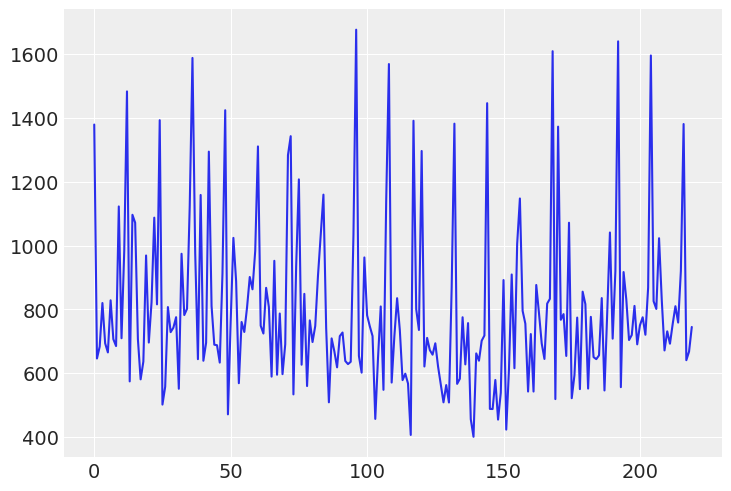

In [26]:
series = 1
X = np.arange(220).reshape(-1,1)
X_new = np.arange(228).reshape(-1,1)

plt.plot(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series]);

In [27]:
with pm.Model() as model:

    l_t = pm.InverseGamma('l_t', 4, 220, testval=40)
    l_ts = pm.Gamma('l_ts', 5, 1, testval=1)
    l_p = pm.InverseGamma('l_p', 4, 220, testval=40)
    η_trend = pm.HalfNormal('η_trend', 1, testval=1.5)
    η_per = pm.HalfNormal('η_per', 3, testval=3)
    η_ts = pm.HalfNormal('η_ts',0.2, testval=0.4)
    σ  = pm.HalfNormal("σ",  sigma=0.15, testval=0.3)
    
    a = pm.Normal('a', 
                  np.log(np.mean(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])),
                  0.1)
    #b = pm.Normal('b', mu=0, sd=0.1, testval=0.1)

    #mu_func = pm.gp.mean.Constant(a)

    # cov function for the GP 
    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
            + η_ts**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_ts)
            + η_per**2 * pm.gp.cov.Periodic(1, period=12, ls=l_p)
            + pm.gp.cov.WhiteNoise(σ))

    gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(a), cov_func=cov)
    f = gp.prior('f', X=X, reparameterize=True)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])
    #prior_checks = pm.sample_prior_predictive(200)
    mp = pm.find_MAP(maxeval=5000, progressbar = True)

In [29]:
with pm.Model() as model:
    f_n0 = gp.conditional('f_n0', Xnew=X_new)

    y_pred_new0 = pm.Poisson("y_pred_new0", 
                            mu=tt.exp(f_n0), 
                            shape=X_new.shape[0])

    pred_samples0 = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new0], 
                                              samples=50,
                                              progressbar = False)

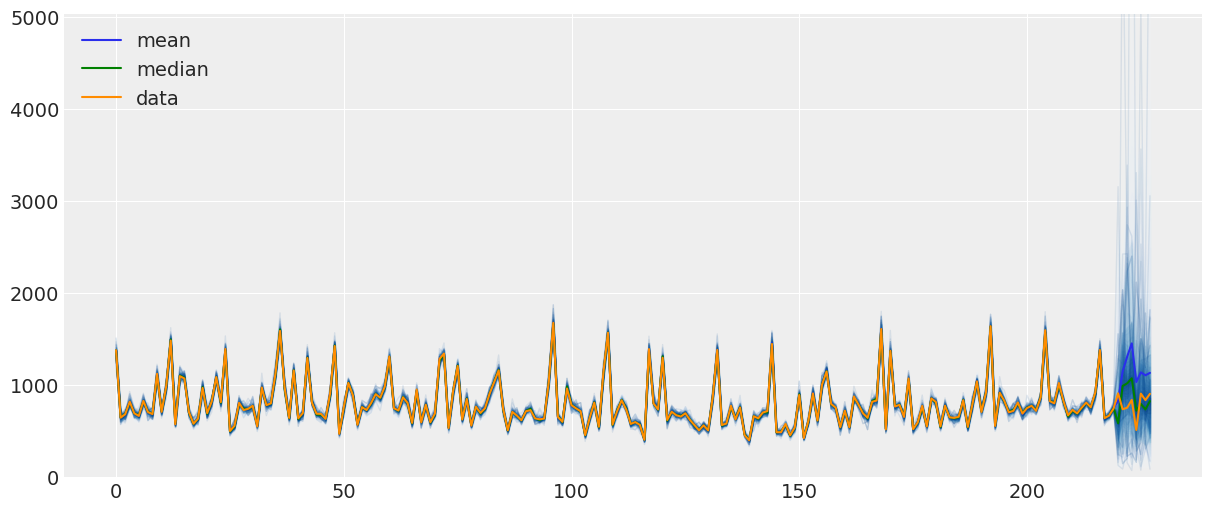

In [30]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples0['y_pred_new0'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.mean(pred_samples0['y_pred_new0'], axis=0), label='mean')
plt.plot(np.median(pred_samples0['y_pred_new0'], axis=0), label='median', color='green')
plt.plot(np.arange(groups['predict']['n']),groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series], label='data', color='darkorange')
plt.ylim(0,max(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])*3)
plt.legend();